  <div class="alert alert-info">
  Привет, Кирилл! Меня зовут Светлана Чих и я буду проверять твой проект. Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе. Предлагаю общаться на «ты». Но если это не удобно - дай знать, и мы перейдем на «вы».

  <div class="alert alert-success">
  <b>👍 Успех:</b> Зелёным цветом отмечены удачные и элегантные решения, на которые можно опираться в будущих проектах.
  </div>
  <div class="alert alert-warning">
  <b>🤔 Рекомендация:</b> Жёлтым цветом выделено то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас (однако это не обязательно).
  </div>
  <div class="alert alert-danger">
  <b>😔 Необходимо исправить:</b> Красным цветом выделены комментарии, без исправления которых, я не смогу принять проект :(
  </div>
  <div class="alert alert-info">
  <b>👂 Совет:</b> Какие-то дополнительные материалы
  </div>
  Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом.
  Мне будет легче отследить изменения, если ты выделишь свои комментарии:
  <div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Например, вот так.</div>
  Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Всё это поможет выполнить повторную проверку твоего проекта быстрее.
   </div>

# Accidents prediction 🚗

Поступил заказ от каршеринговой компании: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

**Содержание**<a id='toc0_'></a>    
1. [Подготовка       ](#toc1_)    
1.1. [Библиотеки       ](#toc1_1_)    
1.2. [Конфигурация       ](#toc1_2_)    
1.3. [Сервисные функции    ](#toc1_3_)    
2. [Первичный осмотр таблиц       ](#toc2_)    
2.1. [Таблица `collisions`       ](#toc2_1_)    
2.2. [Таблица `parties`     ](#toc2_2_)    
2.3. [Таблица `vehicles`     ](#toc2_3_)    
2.4. [Выводы     ](#toc2_4_)    
3. [Статистический анализ факторов ДТП      ](#toc3_)    
3.1. [Самый частый месяц ДТП      ](#toc3_1_)    
3.2. [Задачи для коллег    ](#toc3_2_)    
3.3. [Реализации задачи 1    ](#toc3_3_)    
3.4. [Реализация задачи 5    ](#toc3_4_)    
4. [Данные    ](#toc4_)    
4.1. [Загрузка данных    ](#toc4_1_)    
4.2. [Замена "пустышек" на NaN   ](#toc4_2_)    
4.3. [Проверка типов данных    ](#toc4_3_)    
4.4. [Оптимизация памяти    ](#toc4_4_)    
4.5. [Проверка полных дубликатов    ](#toc4_5_)    
4.6. [Проверка пропусков    ](#toc4_6_)    
4.7. [Изучение признаков   ](#toc4_7_)    
4.7.1. [Таргет `at_fault`   ](#toc4_7_1_)    
4.7.2. [Признак `distance`   ](#toc4_7_2_)    
4.7.3. [Признак `lighting`   ](#toc4_7_3_)    
4.7.4. [Признак `weather`   ](#toc4_7_4_)    
4.7.5. [Признак `road_condition`   ](#toc4_7_5_)    
4.7.6. [Признак `road_surface`   ](#toc4_7_6_)    
4.7.7. [Признак `vehicle_transmission`   ](#toc4_7_7_)    
4.7.8. [Признак `party_sobriety`   ](#toc4_7_8_)    
4.7.9. [Признак `vehicle_age`   ](#toc4_7_9_)    
4.7.10. [Признак `direction`   ](#toc4_7_10_)    
4.7.11. [Признак `cellphone_in_use`   ](#toc4_7_11_)    
4.8. [Корреляция    ](#toc4_8_)    
4.9. [Вывод    ](#toc4_9_)    
5. [Разделение данных    ](#toc5_)    
6. [Модели  ](#toc6_)    
6.1. [Подготовка  ](#toc6_1_)    
6.2. [Модель `CatBoostClassifier`  ](#toc6_2_)    
6.3. [Модель `LGBMClassifier`  ](#toc6_3_)    
6.4. [Модель `RandomForestClassifier`  ](#toc6_4_)    
7. [Результаты  ](#toc7_)    
7.1. [Метрика на трейне  ](#toc7_1_)    
7.2. [Проверка на тесте  ](#toc7_2_)    
7.3. [Важность признаков  ](#toc7_3_)    
8. [Общий вывод    ](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>Подготовка        [&#8593;](#toc0_)

### 1.1. <a id='toc1_1_'></a>Библиотеки        [&#8593;](#toc0_)

In [1]:
from IPython.display import clear_output

In [2]:
%pip install -q catboost==1.2.7
%pip install -q hyperopt==0.2.7
%pip install -q lightgbm==4.5.0
%pip install -q matplotlib==3.9.2
%pip install -q numpy==1.26.4
%pip install -q pandas==2.2.3
%pip install -q psycopg2==2.9.9
%pip install -q phik==0.12.4
%pip install -q prettytable==3.12.0
%pip install -q scikit-learn==1.5.2
%pip install -q seaborn==0.13.2
%pip install -q shap==0.46.0
%pip install -q statsmodels==0.14.4
%pip install -q sqlalchemy==2.0.37
%pip install -q termcolor==2.5.0

clear_output()

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# Models
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Hyperparams tuning
from hyperopt import (hp,
                      fmin,
                      tpe,
                      Trials,
                      STATUS_OK)

from sklearn.base import (BaseEstimator,
                          TransformerMixin)
from sklearn.preprocessing import (StandardScaler,
                                   OrdinalEncoder)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     StratifiedKFold)
from sklearn.metrics import (ConfusionMatrixDisplay,
                             classification_report,
                             roc_auc_score,
                             recall_score)

from sqlalchemy import create_engine
from termcolor import colored
from prettytable import PrettyTable
from phik import phik_matrix  # this import IS accessed
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.mosaicplot import mosaic

/Users/rivel/anaconda3/envs/ml12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<div class="alert alert-success">
<b>👍 Успех:</b> Импортированы нужные библиотеки!
</div>

### 1.2. <a id='toc1_2_'></a>Конфигурация        [&#8593;](#toc0_)

In [4]:
RANDOM_STATE = 27
TEST_SIZE = 0.2

In [5]:
pd.options.display.max_columns = 50

In [6]:
user = 'praktikum_student'
pwd = 'Sdf4$2;d-d30pp'
host = 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net'
port = 6432
db = 'data-science-vehicle-db'

In [7]:
connection_string = f'postgresql://{user}:{pwd}@{host}:{port}/{db}'
engine = create_engine(connection_string)

In [8]:
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-success">
<b>👍 Успех:</b> Определены константы и настройки!
</div>

### 1.3. <a id='toc1_3_'></a>Сервисные функции     [&#8593;](#toc0_)

In [9]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    """Function optimizes memory usage in dataframe

    Args:
        df (pd.DataFrame): DataFrame to optimize.
        print_size (bool, optional): display of optimization results. Defaults to True.

    Returns:
        pd.DataFrame: optimized DataFrame
    """

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)

    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size:
        print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                            .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [10]:
def check_duplicates(df: pd.DataFrame) -> None:
    duplicates_count = df.duplicated().sum()

    if duplicates_count == 0:
        print(colored('Полных дубликатов не обнаружено.', 'green'))
        return

    duplicates_part = duplicates_count / len(df)
    print(colored(f'Обнаружено {duplicates_count} дубликатов ({duplicates_part:.2%})', 'red'))

In [11]:
def check_nans(df: pd.DataFrame) -> None:
    if df.isna().sum().sum() == 0:
        print(colored('Полных дубликатов не обнаружено.', 'green'))
        return

    table = PrettyTable()
    table.field_names = ['Feature', 'Missing values count']

    missing_info = df.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'green' if count == 0 else 'red'
        s = f'{count} ({count / len(df):.2%})'
        table.add_row([col, colored(s, color)])

    print(table)

In [12]:
def get_info_about_nan_in_series(series: pd.Series) -> None:
    nan_cnt = series.isna().sum()
    text = colored('No missing values', 'green') if nan_cnt == 0 \
        else colored(f'{nan_cnt} ({nan_cnt / len(series):.2%})', 'red')
    print(text)

In [13]:
def get_value_counts(series: pd.Series) -> None:
    data = pd.DataFrame()
    data['count'] = series.value_counts()
    data['part'] = data['count'] / len(series)
    display(data)

In [14]:
def draw_plots_about_column(df: pd.DataFrame,
                            column: str,
                            column_description: str = None,
                            bins: int = 20
                            ) -> None:
    if column_description is None:
        column_description = column

    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    sns.violinplot(df, x=column, ax=ax1, orient='h')
    ax1.set_xlabel(column_description)
    ax1.grid()

    sns.boxplot(df, x=column, ax=ax2)
    ax2.set_xlabel(column_description)
    ax2.grid()

    sns.histplot(df, x=column, bins=bins, ax=ax3)
    ax3.set_xlabel(column_description)
    ax3.grid()
    ax3.set_ylabel('Количество')

    ax4.set_visible(False)

    plt.suptitle(f'Информация о колонке `{column_description}`', fontsize=18)
    plt.tight_layout()

    plt.show()

In [15]:
def check_vif_values(df: pd.DataFrame) -> None:
    df = df.select_dtypes(include='number')

    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    with_constants = add_constant(df)

    vif_data = pd.DataFrame()
    vif_data['variable'] = with_constants.columns
    vif_data['vif'] = [variance_inflation_factor(with_constants.values, i) for i in range(with_constants.shape[1])]

    res = vif_data.sort_values(by='vif', ascending=False).reset_index(drop=True)
    display(res)

<div class="alert alert-success">
<b>👍 Успех:</b> Подготовлены нужные функции!
</div>

## 2. <a id='toc2_'></a>Первичный осмотр таблиц        [&#8593;](#toc0_)

### 2.1. <a id='toc2_1_'></a>Таблица `collisions`        [&#8593;](#toc0_)

In [16]:
collisions = pd.read_sql('SELECT * FROM collisions LIMIT 10', engine)
collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [17]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      10 non-null     object 
 1   county_city_location         10 non-null     object 
 2   county_location              10 non-null     object 
 3   distance                     10 non-null     float64
 4   direction                    4 non-null      object 
 5   intersection                 10 non-null     int64  
 6   weather_1                    10 non-null     object 
 7   location_type                5 non-null      object 
 8   collision_damage             10 non-null     object 
 9   party_count                  10 non-null     int64  
 10  primary_collision_factor     10 non-null     object 
 11  pcf_violation_category       9 non-null      object 
 12  type_of_collision            10 non-null     object 
 13  motor_vehicle_involved_

### 2.2. <a id='toc2_2_'></a>Таблица `parties`      [&#8593;](#toc0_)

In [18]:
parties = pd.read_sql('SELECT * FROM parties LIMIT 10', engine)
parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [19]:
parties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10 non-null     int64  
 1   case_id              10 non-null     object 
 2   party_number         10 non-null     int64  
 3   party_type           10 non-null     object 
 4   at_fault             10 non-null     int64  
 5   insurance_premium    4 non-null      float64
 6   party_sobriety       10 non-null     object 
 7   party_drug_physical  4 non-null      object 
 8   cellphone_in_use     9 non-null      float64
dtypes: float64(2), int64(3), object(4)
memory usage: 852.0+ bytes


### 2.3. <a id='toc2_3_'></a>Таблица `vehicles`      [&#8593;](#toc0_)

In [20]:
vehicles = pd.read_sql('SELECT * FROM vehicles LIMIT 10', engine)
vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [21]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    10 non-null     int64 
 1   case_id               10 non-null     object
 2   party_number          10 non-null     int64 
 3   vehicle_type          10 non-null     object
 4   vehicle_transmission  10 non-null     object
 5   vehicle_age           10 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


### 2.4. <a id='toc2_4_'></a>Выводы      [&#8593;](#toc0_)

По результатам первичного исследования можно сделать, что все 3 таблицы указанные в ТЗ имеются. Все данные соответствуют описанию. Пустых столбцов нет, хоть и присутствуют столбцы с пропусками (что часто несет в себе определенную информацию). С помощью столбца `case_id` таблицы могут быть объединены.

<div class="alert alert-success">
<b>👍 Успех:</b> Таблицы просмотрены! Молодец, что выгружаешь только 10 строк, этого достаточно, что бы посмотреть на данные и не расходует много ресурсов
</div>

## 3. <a id='toc3_'></a>Статистический анализ факторов ДТП       [&#8593;](#toc0_)

### 3.1. <a id='toc3_1_'></a>Самый частый месяц ДТП       [&#8593;](#toc0_)

Для начала посмотрим равномерно ли представлена информация.

In [22]:
query = '''
SELECT DATE_PART('year', collision_date) AS year,
       COUNT(DISTINCT DATE_PART('month', collision_date)) as month_count
FROM collisions
GROUP BY DATE_PART('year', collision_date)
ORDER BY year
'''

In [23]:
pd.read_sql(query, engine)

,year,month_count
0,2009.0,12
1,2010.0,12
2,2011.0,12
3,2012.0,12
4,2013.0,6
5,2020.0,2


Как видим, информация о `2013` и `2020` годах представлена не полностью. Поэтому не будем включать их в рассмотрение. Изучим другие года дополнительно.

<div class="alert alert-danger">
<b>😔 Необходимо исправить:</b> Нужно проверить данные по каждому месяцу каждого года, по остальным годам данные полные? Если какие то данные за месяц есть в таблице, то без понимания их количества нельзя судить о полноте данных
</div>

In [24]:
query = '''
SELECT DATE_PART('year', collision_date) AS year,
       DATE_PART('month', collision_date) AS month,
       COUNT(*)
FROM collisions
WHERE DATE_PART('year', collision_date) BETWEEN 2009 AND 2012
GROUP BY year,
         month
'''

In [25]:
res = pd.read_sql(query, engine)
res.head()

,year,month,count
0,2009.0,1.0,35062
1,2009.0,2.0,34480
2,2009.0,3.0,36648
3,2009.0,4.0,35239
4,2009.0,5.0,36916


In [26]:
res.describe()

,year,month,count
count,48.000000,48.000000,48.000000
mean,2010.500000,6.500000,29160.270833
std,1.129865,3.488583,12064.956347
min,2009.000000,1.000000,200.000000
25%,2009.750000,3.750000,31924.000000
50%,2010.500000,6.500000,34270.500000
75%,2011.250000,9.250000,35086.750000
max,2012.000000,12.000000,37835.000000


По каким-то месяцам совсем мало информации, скорее всего она (информация) представлена не полностью. Посмотрим, что за года и исключим их из исследования.

In [27]:
mask = res['count'] < 30_000
res[mask]

,year,month,count
39,2012.0,4.0,29143
40,2012.0,5.0,25168
41,2012.0,6.0,3062
42,2012.0,7.0,390
43,2012.0,8.0,622
44,2012.0,9.0,510
45,2012.0,10.0,304
46,2012.0,11.0,253
47,2012.0,12.0,200


Да, информации по второй половине 2012 года совсем мало, исключим его из рассмотрения.

<div class='alert alert-info'>
<h3>Комментарий студента 👨‍🎓</h3>
<p>Поправил 🤝</p>
</div>

In [28]:
query = '''
SELECT DATE_PART('month', collision_date) AS month,
       COUNT(DISTINCT case_id)
FROM collisions
WHERE DATE_PART('year', collision_date) BETWEEN 2009 AND 2011
GROUP BY month
'''

In [29]:
result = pd.read_sql(query, engine)
result['month'] = result['month'].astype(int)
result

,month,count
0,1,99880
1,2,98373
2,3,107036
3,4,101032
4,5,105148
5,6,99531
6,7,101835
7,8,103467
8,9,104649
9,10,111933


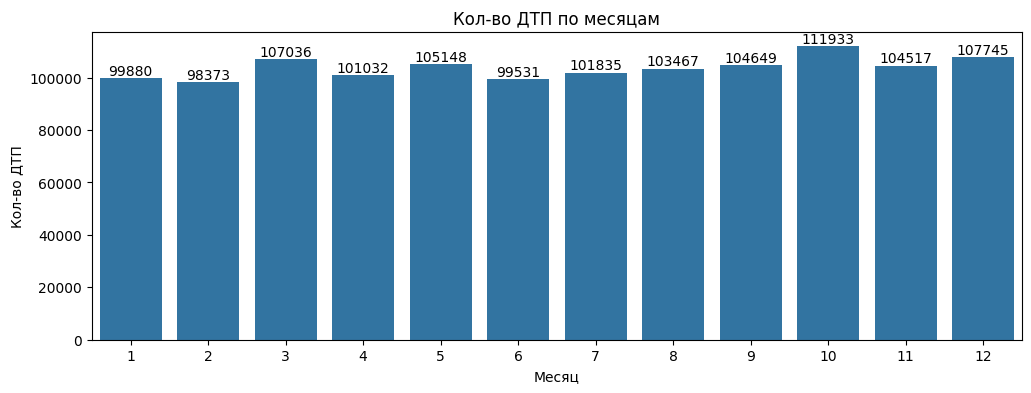

In [30]:
plt.figure(figsize=(12, 4))
barplot = sns.barplot(result, x='month', y='count');
plt.title('Кол-во ДТП по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Кол-во ДТП')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom')

plt.show()

Самым "аварийным" месяцем оказался октябрь. Данный факт можно объяснить погодой, так как в октябре уже начинается снег, из-за чего часто на дорогах гололедица. Такими же погодными условиями можно, предположительно, объяснить большое количество аварий в марте и декабре. Однако на данный момент это лишь гипотезы, которые требуют дополнительного исследования.

<div class='alert alert-info'>
<h3>Комментарий студента 👨‍🎓</h3>
<p>Вывод обновил тут</p>
</div>

### 3.2. <a id='toc3_2_'></a>Задачи для коллег     [&#8593;](#toc0_)

Коллегам предлагается решить следующие задачи:

1) Проведите анализ серьезности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (`collisions` + `parties`)
2) Найдите самые частые причины ДТП (таблица `parties`)
3) Влияет ли алкоголь на количество аварий, то есть больше ли случаев ДТП с участием пьяных водителей по сравнению с трезвыми (таблица `parties`)
4) Является ли перекресток аварийно опасным участком (то есть там больше ДТП, чем не на перекрестках)? (таблица `collisions`)
5) Есть ли связь между серьезностью повреждений транспортного средства и трезвостью водителя? (`collisions` + `parties`)
6) Влияет ли возраст автомобиля на частоту попадания в ДТП?

<div class="alert alert-success">
<b>👍 Успех:</b> Отличные задачи!
</div>

### 3.3. <a id='toc3_3_'></a>Реализации задачи 1     [&#8593;](#toc0_)

**План выполнения задачи:**
1) Создать SQL запрос (не забыть объединить таблицы)
2) Построить график
3) Сделать вывод

In [31]:
query = '''
SELECT collision_damage,
       road_condition_1
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
'''

In [32]:
res = pd.read_sql(query, engine)
res.sample(5, random_state=RANDOM_STATE)

,collision_damage,road_condition_1
1212462,small damage,normal
1643404,small damage,normal
2322143,small damage,normal
75685,small damage,normal
1630974,scratch,normal


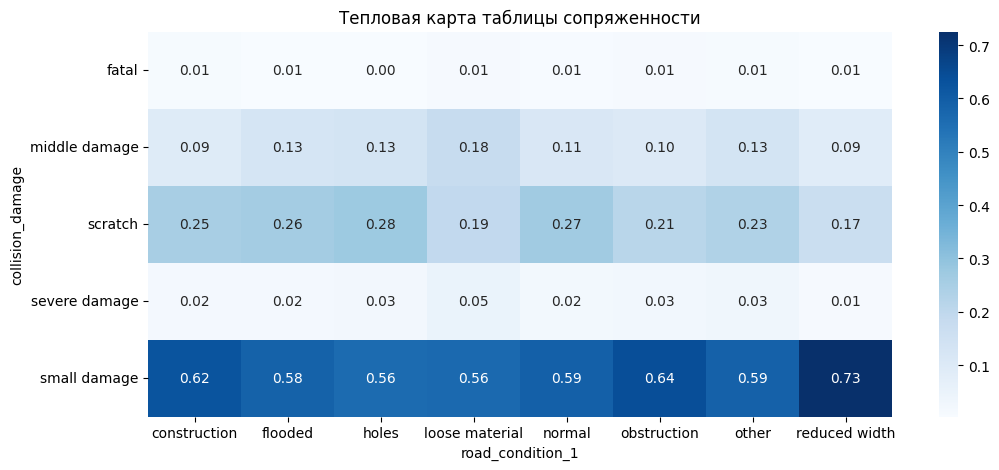

In [33]:
plt.figure(figsize=(12, 5))
rel_crosstab = pd.crosstab(res['collision_damage'], res['road_condition_1'], normalize='columns')
sns.heatmap(rel_crosstab, annot=True, fmt='.2f', cmap='Blues')
plt.title('Тепловая карта таблицы сопряженности')
plt.show()

По графику видно, что наблюдается небольшая связь между состоянием дороги и повреждениями автомобиля. Например, состояние дороги `loose_material` чаще всего приводит к серьезным повреждениям (`middle damage` и `severe damage`). А вот ямы на дорогах (`holes`) чаще приводят к царапинам и практически никогда не приводят к катастрофическим повреждениям (`fatal`).

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

### 3.4. <a id='toc3_4_'></a>Реализация задачи 5     [&#8593;](#toc0_)

План выполнения задачи:
1) Создать SQL запрос (не забыть объединить таблицы)
2) Построить график
3) Сделать вывод

In [34]:
query = '''
SELECT CASE
           WHEN p.party_sobriety IN ('had been drinking, under influence', 'had been drinking, not under influence', 'had been drinking, impairment unknown') THEN 'drunk'
           WHEN p.party_sobriety = 'had not been drinking' THEN 'not drunk'
           ELSE NULL
        END AS drinking_category,
        c.collision_damage
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
WHERE p.party_sobriety IN ('had not been drinking', 'had been drinking, not under influence', 'had been drinking, under influence', 'had been drinking, impairment unknown')
'''

In [35]:
res = pd.read_sql(query, engine)
res.sample(5, random_state=RANDOM_STATE)

,drinking_category,collision_damage
758987,not drunk,small damage
530981,not drunk,small damage
621725,not drunk,small damage
163344,drunk,middle damage
1389848,not drunk,middle damage


In [36]:
res_dict = res.groupby(['drinking_category', 'collision_damage']).size().to_dict()
props = {}
for k in res_dict.keys():
    color = 'red' if k[0] == 'drunk' else 'green'
    props[k] = {'color': color}

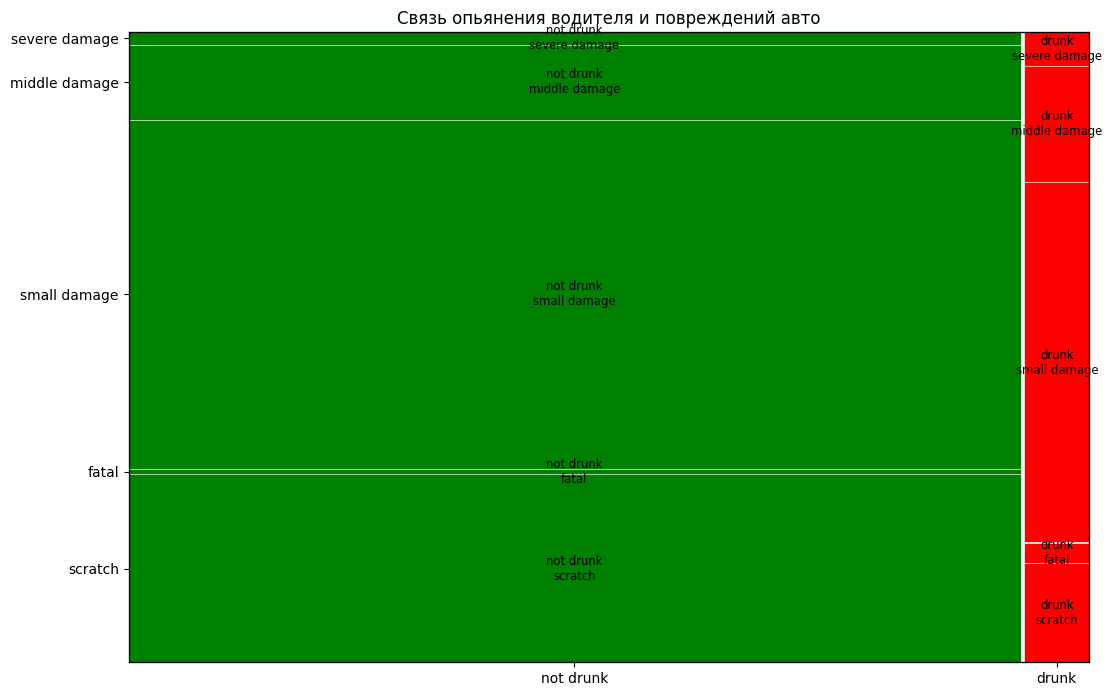

In [37]:
_, ax = plt.subplots(figsize=(12, 7))
mosaic(res, ['drinking_category', 'collision_damage'], ax=ax, title='Связь опьянения водителя и повреждений авто', properties=props)
plt.subplots_adjust(left=0.1, right=0.9, top=1, bottom=0.1)
plt.show()

In [38]:
absolute_counts = res.groupby(['drinking_category', 'collision_damage']).size().reset_index(name='count')
total_counts = res.groupby('drinking_category').size().reset_index(name='total_count')
merged_counts = pd.merge(absolute_counts, total_counts, on='drinking_category')
merged_counts['relative_count'] = merged_counts['count'] / merged_counts['total_count'] * 100

merged_counts \
    .pivot_table(values='relative_count', index='collision_damage', columns='drinking_category') \
    .reindex(['scratch', 'small damage', 'middle damage', 'severe damage', 'fatal']).agg(lambda x: round(x, 2))

drinking_category,drunk,not drunk
collision_damage,,
scratch,15.80,30.06
small damage,57.58,55.79
middle damage,18.40,11.71
severe damage,5.25,1.86
fatal,2.96,0.58


Анализ подтверждает идею - фактор "пьяный ли водитель за рулем" влияет на серьезность повреждений автомобиля. Например, повреждения среднего уровня и выше (`middle damage`, `severe damage` и `fatal`) получили автомобили в `26.6%` ДТП, если водитель был пьян, против `14.2%` при трезвом водителе.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

## 4. <a id='toc4_'></a>Данные     [&#8593;](#toc0_)

### 4.1. <a id='toc4_1_'></a>Загрузка данных     [&#8593;](#toc0_)

Выгрузим только нужные столбцы, также сразу приведем названия признаков к соответствию PEP8.

In [39]:
query = '''
SELECT distance,
       direction,
       weather_1 AS weather,
       location_type,
       road_surface,
       road_condition_1 AS road_condition,
       lighting,
       control_device,
       at_fault,
       party_sobriety,           -- Уровень трезвости точно влияет
       party_drug_physical,      -- Сонное состояние или нахождение под препаратами может влиять
       cellphone_in_use,         -- Использование телефона во время вождения может влиять
       vehicle_transmission,     -- Теоретически тип КПП может влиять
       vehicle_age               -- Возраст автомобиля влияет на его состояние
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
WHERE c.collision_damage != 'scratch'
      AND DATE_PART('year', c.collision_date) = 2012
      AND p.party_type = 'car'
'''

<div class="alert alert-danger">
<b>😔 Необходимо исправить:</b> vehicles имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number. После изменения запроса вся часть ниже измениться, поэтому я проверю ее в следующей итерации
</div>

<div class='alert alert-info'>
<h3>Комментарий студента 👨‍🎓</h3>
<p>Поправил 🤝</p>
</div>

In [40]:
df = pd.read_sql(query, engine)
df.head()

,distance,direction,weather,location_type,road_surface,road_condition,lighting,control_device,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_transmission,vehicle_age
0,1500.0,south,clear,highway,dry,normal,dark with street lights,none,1,impairment unknown,G,0.0,manual,3.0
1,150.0,north,clear,highway,None,holes,daylight,none,0,had not been drinking,None,0.0,auto,0.0
2,100.0,west,clear,highway,dry,normal,daylight,none,0,had not been drinking,None,0.0,auto,5.0
3,832.0,north,clear,None,dry,normal,daylight,none,0,had not been drinking,None,0.0,manual,2.0
4,0.0,None,clear,None,dry,normal,daylight,functioning,1,had not been drinking,None,0.0,manual,NaN


<div class="alert alert-warning">
<b>🤔 Рекомендация:</b> Отличный набор признаков! Стоит сразу в запросе выгружать только эти столбцы
</div>

<div class='alert alert-info'>
<h3>Комментарий студента 👨‍🎓</h3>
<p>Согласен, хорошая идея</p>
</div>

### 4.2. <a id='toc4_2_'></a>Замена "пустышек" на NaN    [&#8593;](#toc0_)

In [41]:
df.isna().sum().sum()

105755

In [42]:
df = df.replace(['None', 'none', '-', '', None], np.nan)

In [43]:
df.isna().sum().sum()

143333

### 4.3. <a id='toc4_3_'></a>Проверка типов данных     [&#8593;](#toc0_)

In [44]:
df.head()

,distance,direction,weather,location_type,road_surface,road_condition,lighting,control_device,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_transmission,vehicle_age
0,1500.0,south,clear,highway,dry,normal,dark with street lights,NaN,1,impairment unknown,G,0.0,manual,3.0
1,150.0,north,clear,highway,NaN,holes,daylight,NaN,0,had not been drinking,NaN,0.0,auto,0.0
2,100.0,west,clear,highway,dry,normal,daylight,NaN,0,had not been drinking,NaN,0.0,auto,5.0
3,832.0,north,clear,NaN,dry,normal,daylight,NaN,0,had not been drinking,NaN,0.0,manual,2.0
4,0.0,NaN,clear,NaN,dry,normal,daylight,functioning,1,had not been drinking,NaN,0.0,manual,NaN


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              56248 non-null  float64
 1   direction             43230 non-null  object 
 2   weather               56080 non-null  object 
 3   location_type         25932 non-null  object 
 4   road_surface          55900 non-null  object 
 5   road_condition        55999 non-null  object 
 6   lighting              56094 non-null  object 
 7   control_device        18455 non-null  object 
 8   at_fault              56248 non-null  int64  
 9   party_sobriety        55376 non-null  object 
 10  party_drug_physical   2857 non-null   object 
 11  cellphone_in_use      51777 non-null  float64
 12  vehicle_transmission  55389 non-null  object 
 13  vehicle_age           54554 non-null  float64
dtypes: float64(3), int64(1), object(10)
memory usage: 6.0+ MB


Все типы данных указаны верно.

### 4.4. <a id='toc4_4_'></a>Оптимизация памяти     [&#8593;](#toc0_)

In [46]:
df = optimize_memory_usage(df)

Размер использования памяти: до  6.01 Mb - после  4.99 Mb (17.0%)


### 4.5. <a id='toc4_5_'></a>Проверка полных дубликатов     [&#8593;](#toc0_)

In [47]:
check_duplicates(df)

Обнаружено 14080 дубликатов (25.03%)


In [48]:
df = df.drop_duplicates()

In [49]:
check_duplicates(df)

Полных дубликатов не обнаружено.


### 4.6. <a id='toc4_6_'></a>Проверка пропусков     [&#8593;](#toc0_)

In [50]:
check_nans(df)

+----------------------+----------------------+
|       Feature        | Missing values count |
+----------------------+----------------------+
|       distance       |      0 (0.00%)       |
|       at_fault       |      0 (0.00%)       |
|       lighting       |     153 (0.36%)      |
|       weather        |     167 (0.40%)      |
|    road_condition    |     245 (0.58%)      |
|     road_surface     |     341 (0.81%)      |
| vehicle_transmission |     747 (1.77%)      |
|    party_sobriety    |     853 (2.02%)      |
|     vehicle_age      |     1339 (3.18%)     |
|   cellphone_in_use   |     3539 (8.39%)     |
|      direction       |     3968 (9.41%)     |
|    location_type     |    21107 (50.05%)    |
|    control_device    |    31300 (74.23%)    |
| party_drug_physical  |    39398 (93.43%)    |
+----------------------+----------------------+


Признаки `party_drug_physical`, `control_device` и `location_type` имеют слишком большую часть пропусков. Разумнее всего удалить их.

In [51]:
df = df.drop(columns=['party_drug_physical', 'control_device', 'location_type'], errors='ignore')

In [52]:
check_nans(df)

+----------------------+----------------------+
|       Feature        | Missing values count |
+----------------------+----------------------+
|       distance       |      0 (0.00%)       |
|       at_fault       |      0 (0.00%)       |
|       lighting       |     153 (0.36%)      |
|       weather        |     167 (0.40%)      |
|    road_condition    |     245 (0.58%)      |
|     road_surface     |     341 (0.81%)      |
| vehicle_transmission |     747 (1.77%)      |
|    party_sobriety    |     853 (2.02%)      |
|     vehicle_age      |     1339 (3.18%)     |
|   cellphone_in_use   |     3539 (8.39%)     |
|      direction       |     3968 (9.41%)     |
+----------------------+----------------------+


### 4.7. <a id='toc4_7_'></a>Изучение признаков    [&#8593;](#toc0_)

#### 4.7.1. <a id='toc4_7_1_'></a>Таргет `at_fault`    [&#8593;](#toc0_)

In [53]:
get_value_counts(df['at_fault'])

,count,part
at_fault,,
1,22611,0.536212
0,19557,0.463788


Датасет с небольшим перевесом класса `1`.

#### 4.7.2. <a id='toc4_7_2_'></a>Признак `distance`    [&#8593;](#toc0_)

In [54]:
df['distance'].describe()

count    4.216800e+04
mean     1.054406e+03
std      8.340980e+03
min      0.000000e+00
25%      4.500000e+01
50%      2.000000e+02
75%      7.800000e+02
max      1.584000e+06
Name: distance, dtype: float64

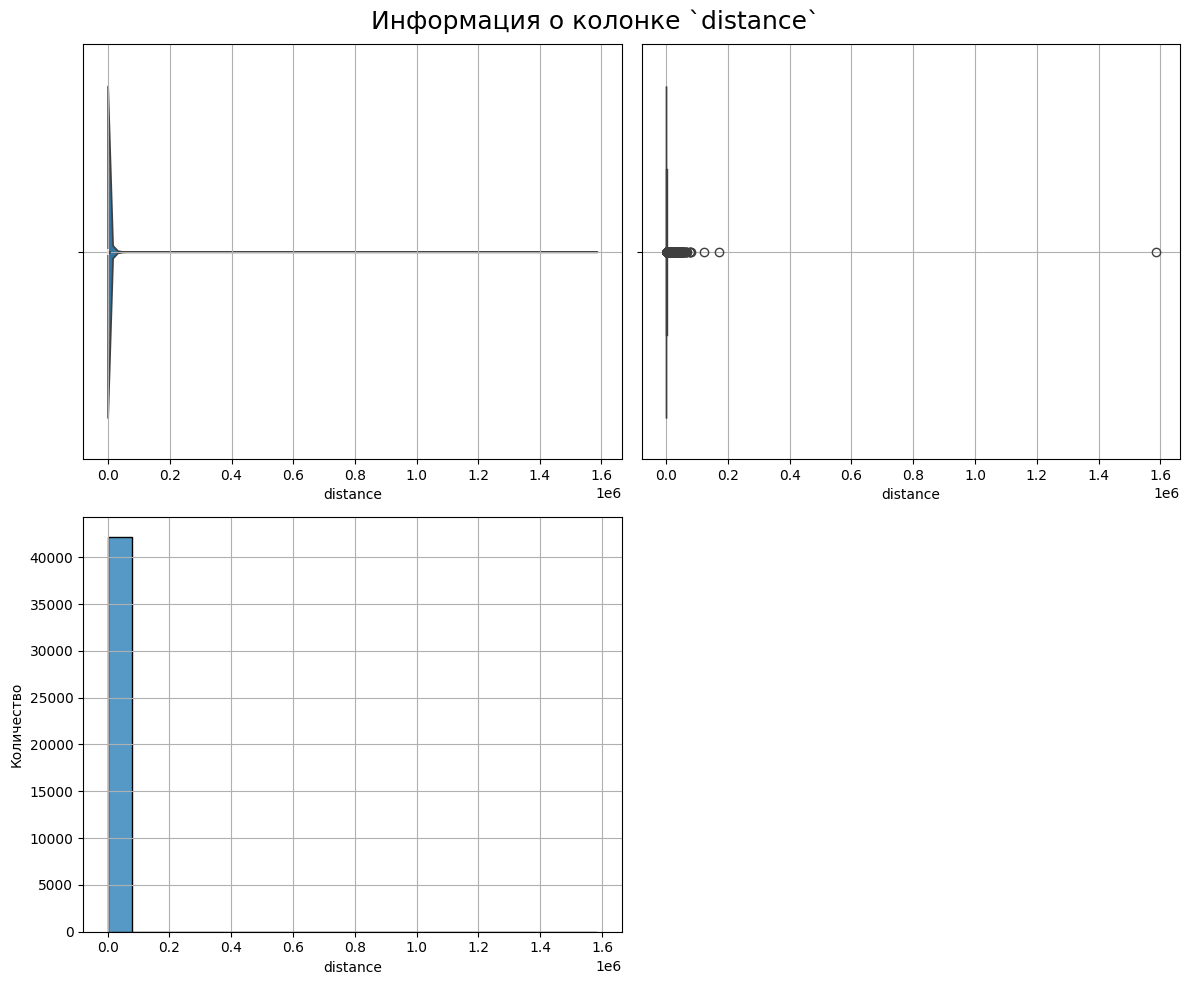

In [55]:
draw_plots_about_column(df, 'distance')

In [56]:
mask = df['distance'] > 0.2 * 1e6
df[mask]

,distance,direction,weather,road_surface,road_condition,lighting,at_fault,party_sobriety,cellphone_in_use,vehicle_transmission,vehicle_age
27616,1584000.0,north,clear,dry,normal,daylight,1,had not been drinking,0.0,manual,3.0


Два наблюдения сильно выбиваются из всех остальных. Удалим их.

In [57]:
display(df.shape)
df = df[~mask]
display(df.shape)

(42168, 11)

(42167, 11)

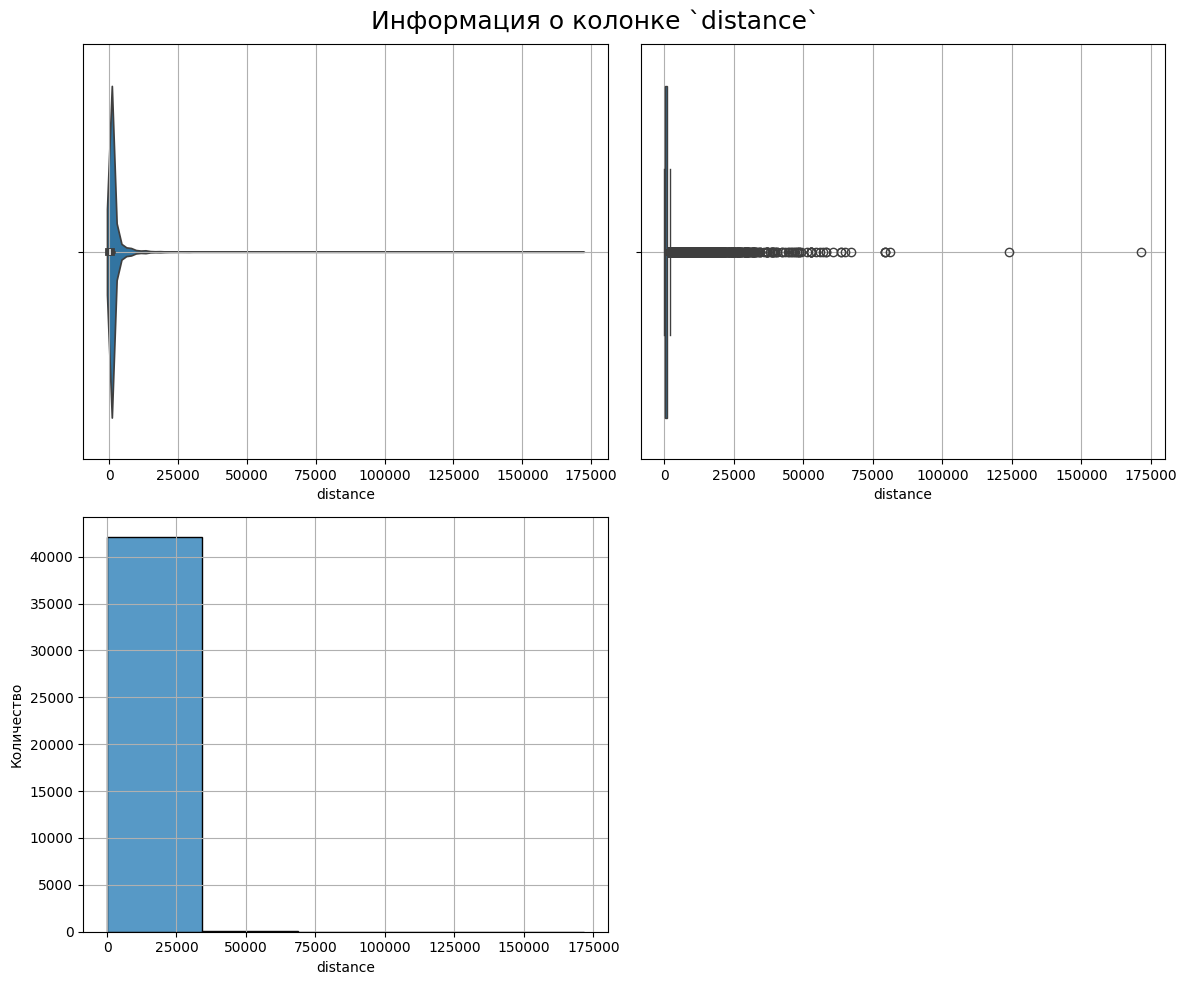

In [58]:
draw_plots_about_column(df, 'distance', bins=5)

#### 4.7.3. <a id='toc4_7_3_'></a>Признак `lighting`    [&#8593;](#toc0_)

In [59]:
get_info_about_nan_in_series(df['lighting'])

153 (0.36%)


In [60]:
get_value_counts(df['lighting'])

,count,part
lighting,,
daylight,26852,0.636801
dark with street lights,8644,0.204994
dark with no street lights,4802,0.113881
dusk or dawn,1581,0.037494
dark with street lights not functioning,135,0.003202


Некоторые категории довольно редкие. Объединим их в более крупные.

In [61]:
def group_lighting_feature(s: str) -> str:
    match s:
        case 'daylight': return 'a lot of light'
        case 'dark with street lights': return 'sufficient light'
        case _: return 'few light'

In [62]:
df['lighting'] = df['lighting'].apply(group_lighting_feature)

In [63]:
get_value_counts(df['lighting'])

,count,part
lighting,,
a lot of light,26852,0.636801
sufficient light,8644,0.204994
few light,6671,0.158204


#### 4.7.4. <a id='toc4_7_4_'></a>Признак `weather`    [&#8593;](#toc0_)

In [64]:
get_info_about_nan_in_series(df['weather'])

167 (0.40%)


In [65]:
get_value_counts(df['weather'])

,count,part
weather,,
clear,32206,0.763773
cloudy,7395,0.175374
raining,2019,0.047881
fog,179,0.004245
snowing,156,0.003700
other,34,0.000806
wind,11,0.000261


Также сгруппируем категории до более крупных.

In [66]:
def group_weather_feature(s: str) -> str:
    match s:
        case 'clear': return 'clear'
        case 'cloudy' | 'fog': return 'cloudy'
        case 'raining' | 'snowing': return 'rainfall'
        case _: return 'other'

In [67]:
df['weather'] = df['weather'].apply(group_weather_feature)

In [68]:
get_value_counts(df['weather'])

,count,part
weather,,
clear,32206,0.763773
cloudy,7574,0.179619
rainfall,2175,0.051581
other,212,0.005028


#### 4.7.5. <a id='toc4_7_5_'></a>Признак `road_condition`    [&#8593;](#toc0_)

In [69]:
get_info_about_nan_in_series(df['road_condition'])

245 (0.58%)


In [70]:
get_value_counts(df['road_condition'])

,count,part
road_condition,,
normal,40019,0.949060
construction,980,0.023241
obstruction,246,0.005834
other,228,0.005407
holes,219,0.005194
loose material,127,0.003012
reduced width,71,0.001684
flooded,32,0.000759


Также сгруппируем категории до более крупных.

In [71]:
def group_road_condition_feature(s: str) -> str:
    return 'normal' if s == 'normal' else 'with obstacles'

In [72]:
df['road_condition'] = df['road_condition'].apply(group_road_condition_feature)

In [73]:
get_value_counts(df['road_condition'])

,count,part
road_condition,,
normal,40019,0.94906
with obstacles,2148,0.05094


#### 4.7.6. <a id='toc4_7_6_'></a>Признак `road_surface`    [&#8593;](#toc0_)

In [74]:
get_info_about_nan_in_series(df['road_surface'])

341 (0.81%)


In [75]:
get_value_counts(df['road_surface'])

,count,part
road_surface,,
dry,36528,0.866270
wet,4899,0.116181
snowy,356,0.008443
slippery,43,0.001020


Также сгруппируем категории до более крупных.

In [76]:
def group_road_surface_feature(s: str) -> str:
    return 'dry' if s == 'dry' else 'hazardous'

In [77]:
df['road_surface'] = df['road_surface'].apply(group_road_surface_feature)

In [78]:
get_value_counts(df['road_surface'])

,count,part
road_surface,,
dry,36528,0.86627
hazardous,5639,0.13373


#### 4.7.7. <a id='toc4_7_7_'></a>Признак `vehicle_transmission`    [&#8593;](#toc0_)

In [79]:
get_info_about_nan_in_series(df['vehicle_transmission'])

747 (1.77%)


In [80]:
get_value_counts(df['vehicle_transmission'])

,count,part
vehicle_transmission,,
manual,22267,0.528067
auto,19153,0.454218


#### 4.7.8. <a id='toc4_7_8_'></a>Признак `party_sobriety`    [&#8593;](#toc0_)

In [81]:
get_info_about_nan_in_series(df['party_sobriety'])

853 (2.02%)


In [82]:
get_value_counts(df['party_sobriety'])

,count,part
party_sobriety,,
had not been drinking,34946,0.828752
"had been drinking, under influence",4123,0.097778
impairment unknown,1179,0.027960
"had been drinking, not under influence",564,0.013375
"had been drinking, impairment unknown",257,0.006095
not applicable,245,0.005810


Видно несколько крайне редких категорий, объединим их.

In [83]:
def group_sobriety_feature(s: str) -> str:
    if s == 'had not been drinking':
        return 'no alcohol'
    elif s in ['not applicable', 'impairment unknown']:
        return 'unknown'
    else:
        return 'with alcohol'

In [84]:
df['party_sobriety'] = df['party_sobriety'].apply(group_sobriety_feature)

In [85]:
get_value_counts(df['party_sobriety'])

,count,part
party_sobriety,,
no alcohol,34946,0.828752
with alcohol,5797,0.137477
unknown,1424,0.033770


#### 4.7.9. <a id='toc4_7_9_'></a>Признак `vehicle_age`    [&#8593;](#toc0_)

In [86]:
get_info_about_nan_in_series(df['vehicle_age'])

1339 (3.18%)


In [87]:
df['vehicle_age'].describe()

count    40828.000000
mean         4.951651
std          3.322978
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max        161.000000
Name: vehicle_age, dtype: float64

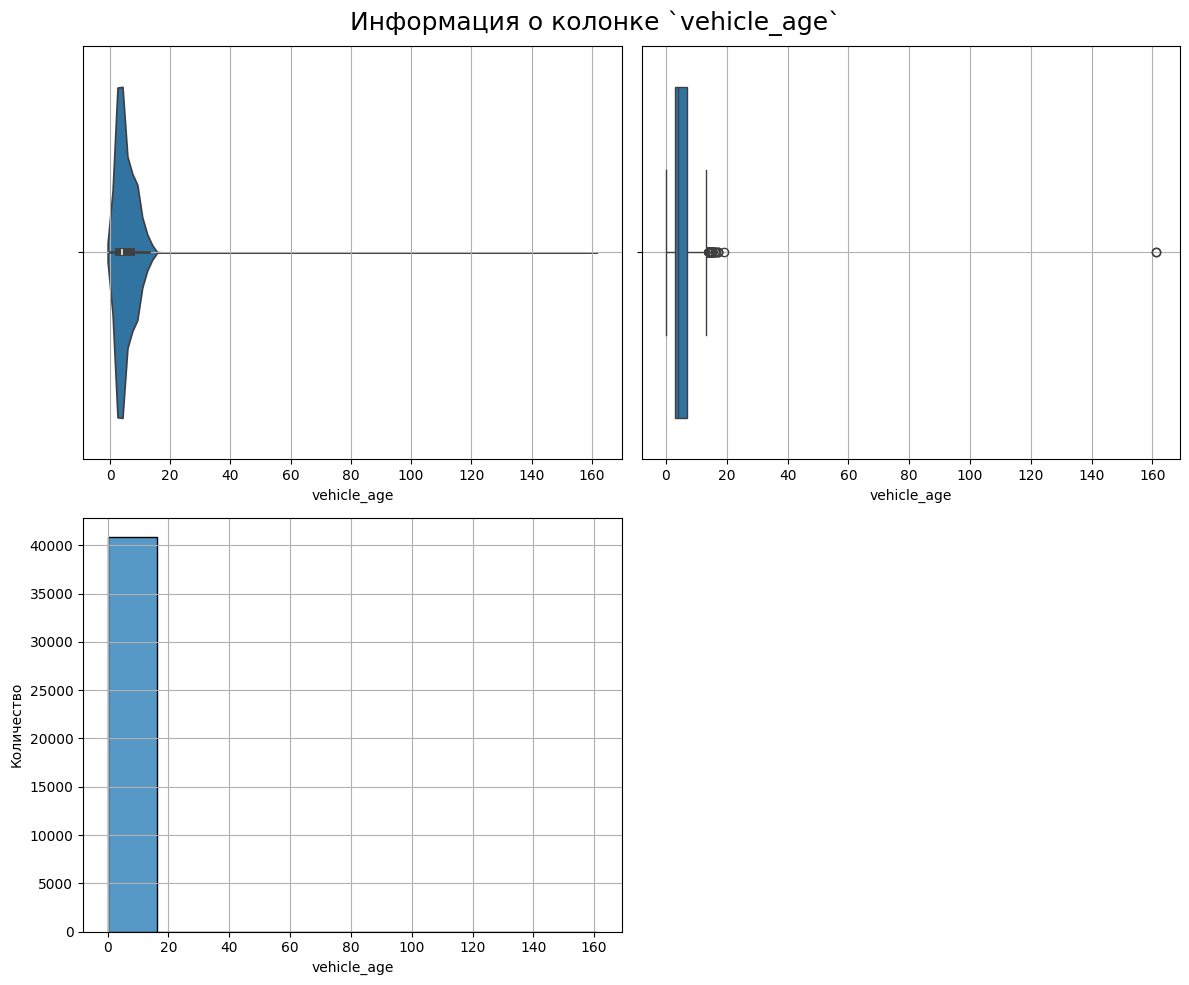

In [88]:
draw_plots_about_column(df, 'vehicle_age', bins=10)

Видим вновь, что есть значения, выбивающиеся из общей картины. Изучим дополнительно.

In [89]:
mask = df['vehicle_age'] > 20
df[mask]

,distance,direction,weather,road_surface,road_condition,lighting,at_fault,party_sobriety,cellphone_in_use,vehicle_transmission,vehicle_age
25978,0.0,NaN,clear,dry,normal,few light,0,no alcohol,0.0,manual,161.0
34657,449.0,north,clear,dry,normal,a lot of light,1,no alcohol,0.0,manual,161.0


Удалим их.

In [90]:
display(df.shape)
df = df[~mask]
display(df.shape)

(42167, 11)

(42165, 11)

#### 4.7.10. <a id='toc4_7_10_'></a>Признак `direction`    [&#8593;](#toc0_)

In [91]:
get_info_about_nan_in_series(df['direction'])

3967 (9.41%)


In [92]:
get_value_counts(df['direction'])

,count,part
direction,,
north,10545,0.250089
south,10270,0.243567
west,8797,0.208633
east,8586,0.203629


#### 4.7.11. <a id='toc4_7_11_'></a>Признак `cellphone_in_use`    [&#8593;](#toc0_)

In [93]:
get_info_about_nan_in_series(df['cellphone_in_use'])

3539 (8.39%)


In [94]:
get_value_counts(df['cellphone_in_use'])

,count,part
cellphone_in_use,,
0.0,37616,0.892114
1.0,1010,0.023954


Так как в этом столбце более `8%` пропусков, имеет смысл перевести значения в текстовую категорию и заполнить пропуски специальным значением, например `unknown` (*это будет делаться в пайплайне*).

In [95]:
def replace_cellphone_feature_values(v: float) -> str:
    return 'no' if v == 0 else 'yes'

In [96]:
df['cellphone_in_use'] =df['cellphone_in_use'].apply(replace_cellphone_feature_values)

In [97]:
get_value_counts(df['cellphone_in_use'])

,count,part
cellphone_in_use,,
no,37616,0.892114
yes,4549,0.107886


### 4.8. <a id='toc4_8_'></a>Корреляция     [&#8593;](#toc0_)

In [98]:
target = 'at_fault'

num_cols = df.select_dtypes(include='number').columns.to_list()
num_cols.remove(target)

cat_cols = df.select_dtypes(exclude='number').columns.to_list()

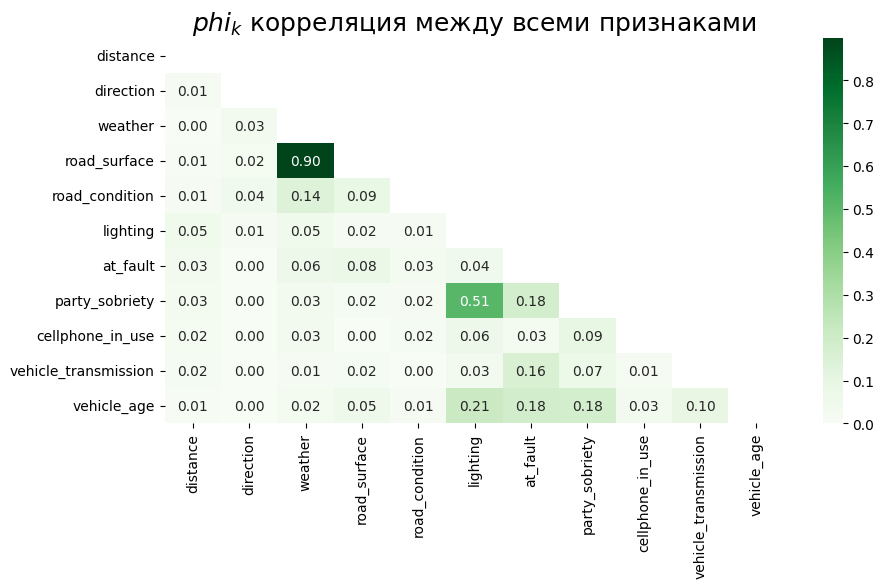

In [99]:
interval_cols = num_cols + [target]

plt.figure(figsize=(10, 5))
correlation_matrix = df.phik_matrix(interval_cols=interval_cols)
mask = np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool)
lower_triangle = correlation_matrix.where(mask)
sns.heatmap(lower_triangle,
            cmap='Greens',
            annot=True,
            fmt='.2f');

plt.title(r'$phi_k$ корреляция между всеми признаками', fontsize=18);

### 4.9. <a id='toc4_9_'></a>Вывод     [&#8593;](#toc0_)

Перед нами датасет с информацией о ДТП, а также участниках и транспортных средствах. Взята информация только за 2012 год, где ДТП привело к любым повреждениям авто, серьезнее царапины.

Датасет содержал довольно большое количество полных дубликатов, которые были удалены. Почти все входные признаки имеют пропуски, которые будут заполнены в пайплайне. Датасет в основном состоит из категориальных признаков, которые были сгруппированы до более крупных.

Некоторые записи, содержащие аномальные значения, были удалены.

Корреляция входных признаков с таргетом практически не наблюдается.

## 5. <a id='toc5_'></a>Разделение данных     [&#8593;](#toc0_)

In [100]:
X = df.drop(columns=target)
y = df[target]

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

## 6. <a id='toc6_'></a>Модели   [&#8593;](#toc0_)

### 6.1. <a id='toc6_1_'></a>Подготовка   [&#8593;](#toc0_)

In [102]:
class ImputeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.impute_transformer = ColumnTransformer([
            ('imputer', SimpleImputer(strategy='constant', fill_value='other'), ['weather']),
            ('imputer_2', SimpleImputer(strategy='constant', fill_value='unknown'), ['vehicle_transmission',
                                                                                    'party_sobriety',
                                                                                    'direction',
                                                                                    'cellphone_in_use',
                                                                                    'lighting',
                                                                                    'road_condition',
                                                                                    'road_surface']),
            ('imputer_3', SimpleImputer(strategy='median'), ['vehicle_age'])
        ], remainder='passthrough', verbose_feature_names_out=False)

    def fit(self, X, _=None):
        self.impute_transformer.fit(X)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        data = self.impute_transformer.transform(X)

        df_transformed = pd.DataFrame(data, columns=self.impute_transformer.get_feature_names_out())

        # Восстанавливаем типы данных
        for col in X.columns:
            if col in df_transformed.columns:
                df_transformed[col] = df_transformed[col].astype(X[col].dtype)

        return df_transformed

---

В качестве метрики выберем `ROC_AUC`, чтобы посмотреть как модель отличает классы. Особое внимание уделим `recall` метрике, чтобы убедиться, что модель не пропускает действительно опасные ситуации.

In [103]:
def get_objective(estimator,
                  X_train: pd.DataFrame,
                  y_train: pd.Series):
    def objective(params: dict) -> float:
        """Кросс-валидация с текущими гиперпараметрами.

        Args:
            estimator: пайплайн с моделью или отдельно модель
            params (dict): гиперпараметры
            X_train (pd.DataFrame): входные признаки (features)
            y_train (pd.Series): целевой признак (target)

        Returns:
            dict: Словарь со средним значением метрики, гиперпараметрами и статусом.
        """
        # Некоторые параметры могут быть только целочисленные, приводим их к нужному типу
        for key, value in params.items():
            if isinstance(value, float) and value % 1 == 0:
                params[key] = int(value)

        estimator.set_params(**params)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        score = cross_val_score(estimator=estimator,
                                X=X_train,
                                y=y_train,
                                scoring='roc_auc',
                                cv=skf,
                                n_jobs=-1)

        return {
            'loss': -score.mean(),
            'params': params,
            'status': STATUS_OK
        }

    return objective

In [104]:
def get_model_results(estimator,
                      param_space: dict,
                      X_train: pd.DataFrame,
                      y_train: pd.Series
                      ) -> tuple[dict, float]:
    objective = get_objective(estimator, X_train, y_train)
    trials = Trials()

    fmin(
        fn=objective,
        space=param_space,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials,
        rstate=np.random.default_rng(RANDOM_STATE),
        show_progressbar=True
    )

    clear_output()

    best_params = trials.best_trial['result']['params']
    best_score = abs(trials.best_trial['result']['loss'])
    print(f'Finish with best ROC_AUC = {best_score:.4f}')

    return best_params, best_score

### 6.2. <a id='toc6_2_'></a>Модель `CatBoostClassifier`   [&#8593;](#toc0_)

In [105]:
cbc_pipeline = Pipeline([
    ('preprocessing', ImputeTransformer()),
    ('model', CatBoostClassifier(random_state=RANDOM_STATE, thread_count=-1, cat_features=cat_cols, silent=True))
])

In [106]:
param_space = {
    'model__iterations': hp.quniform('iterations', 100, 1000, 50),  # число итераций
    'model__learning_rate': hp.loguniform('learning_rate', -5, -1),  # темп обучения
    'model__depth': hp.quniform('depth', 4, 10, 1),  # глубина деревьев
    'model__l2_leaf_reg': hp.loguniform('l2_leaf_reg', 0, 3),  # L2 регуляризация
    'model__border_count': hp.quniform('border_count', 32, 255, 1),  # число разбиений
    'model__random_strength': hp.uniform('random_strength', 0, 10),  # сила случайности
    'model__scale_pos_weight': hp.loguniform('scale_pos_weight', -2, 2),  # вес положительных классов
    'model__bootstrap_type': hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),  # тип bootstrap
    'model__grow_policy': hp.choice('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])  # политика роста
}

In [107]:
best_params_cbc, best_score_cbc = get_model_results(cbc_pipeline, param_space, X_train, y_train)

Finish with best ROC_AUC = 0.6873


### 6.3. <a id='toc6_3_'></a>Модель `LGBMClassifier`   [&#8593;](#toc0_)

In [108]:
class CategoryTypeSetTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols: list[str]):
        super().__init__()
        self.cat_cols = cat_cols

    def fit(self, X, _=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_copy = X.copy()
        X_copy[self.cat_cols] = X_copy[self.cat_cols].astype('category')

        return X_copy

In [109]:
lgbmc_pipeline = Pipeline([
    ('preprocessing', ImputeTransformer()),
    ('category_type_set_transformer', CategoryTypeSetTransformer(cat_cols)),
    ('model', LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1))
])

In [110]:
param_space = {
    'model__num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'model__max_depth': hp.quniform('max_depth', 3, 12, 1),
    'model__learning_rate': hp.loguniform('learning_rate', -5, 0),
    'model__n_estimators': hp.quniform('n_estimators', 100, 1000, 10),
    'model__min_child_samples': hp.quniform('min_child_samples', 5, 100, 1),
    'model__subsample': hp.uniform('subsample', 0.5, 1.0),
    'model__colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'model__reg_alpha': hp.loguniform('reg_alpha', -5, 1),
    'model__reg_lambda': hp.loguniform('reg_lambda', -5, 1)
}

In [111]:
best_params_lgbm, best_score_lgbm = get_model_results(lgbmc_pipeline, param_space, X_train, y_train)

Finish with best ROC_AUC = 0.6856


### 6.4. <a id='toc6_4_'></a>Модель `RandomForestClassifier`   [&#8593;](#toc0_)

In [112]:
class OrdinalEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_encode: list[str]):
        super().__init__()
        self.cols_to_encode = cols_to_encode
        self.encoder = OrdinalEncoder()

    def fit(self, X: pd.DataFrame, _=None):
        self.encoder.fit(X[self.cols_to_encode])
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_copy = X.copy()
        X_copy[self.cols_to_encode] = self.encoder.transform(X_copy[self.cols_to_encode])

        return X_copy

In [113]:
rfc_pipeline = Pipeline([
    ('preprocessing', ImputeTransformer()),
    ('ordinal_encoder_transformer', OrdinalEncoderTransformer(cat_cols)),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

In [114]:
param_space = {
    'model__n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'model__max_depth': hp.quniform('max_depth', 5, 50, 1),
    'model__min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'model__min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1),
    'model__max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'model__class_weight': hp.choice('class_weight', ['balanced', {0: 1, 1: 49}]),
    'model__criterion': hp.choice('criterion', ['gini', 'entropy']),
    'model__bootstrap': hp.choice('bootstrap', [True, False])
}

In [115]:
best_params_rfc, best_score_rfc = get_model_results(rfc_pipeline, param_space, X_train, y_train)

Finish with best ROC_AUC = 0.6829


## 7. <a id='toc7_'></a>Результаты   [&#8593;](#toc0_)

### 7.1. <a id='toc7_1_'></a>Метрика на трейне   [&#8593;](#toc0_)

In [116]:
pd.options.display.float_format = '{:.4f}'.format

pd.DataFrame(
    data=[best_score_rfc, best_score_cbc, best_score_lgbm],
    index=['RandomForestClassifier', 'CatBoostClassifier', 'LGBMClassifier'],
    columns=['roc_auc']
).sort_values('roc_auc', ascending=False)

,roc_auc
CatBoostClassifier,0.6873
LGBMClassifier,0.6856
RandomForestClassifier,0.6829


### 7.2. <a id='toc7_2_'></a>Проверка на тесте   [&#8593;](#toc0_)

In [117]:
cbc_pipeline.set_params(**best_params_cbc);

In [118]:
cbc_pipeline.fit(X_train, y_train);

In [119]:
y_pred = cbc_pipeline.predict(X_test)
y_pred_proba = cbc_pipeline.predict_proba(X_test)[:, 1]

In [120]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
recall = recall_score(y_test, y_pred)
print(f'ROC-AUC on test = {roc_auc:.4f}\n recall on test = {recall:.4f}')

ROC-AUC on test = 0.6826
 recall on test = 0.2430


In [121]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.96      0.68      3911
           1       0.88      0.24      0.38      4522

    accuracy                           0.58      8433
   macro avg       0.70      0.60      0.53      8433
weighted avg       0.72      0.58      0.52      8433



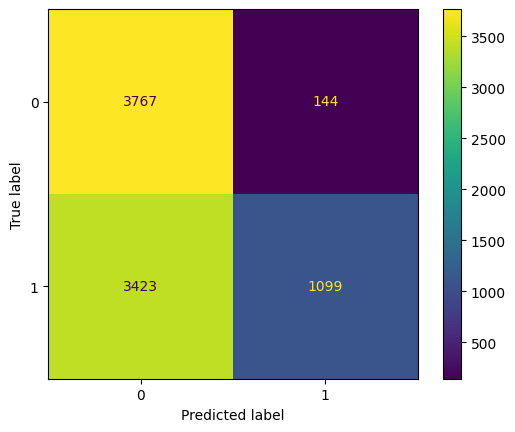

In [122]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

### 7.3. <a id='toc7_3_'></a>Важность признаков   [&#8593;](#toc0_)

In [123]:
impute_transformer = ImputeTransformer()
impute_transformer.fit(X_train)
X_test_processed = impute_transformer.transform(X_test)

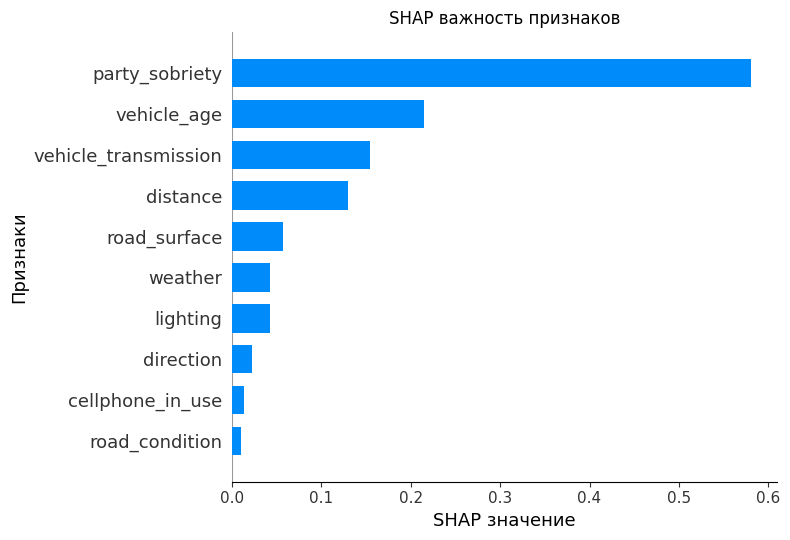

In [124]:
best_model = cbc_pipeline.named_steps['model']

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_processed)

shap.summary_plot(shap_values, X_test_processed, color_bar_label='Признаки', show=False, plot_type='bar', show_values_in_legend=True, max_display=100)
plt.title('SHAP важность признаков')
plt.xlabel('SHAP значение')
plt.ylabel('Признаки', fontsize=13)

plt.tight_layout()
plt.show()

---

Дополнительно изучим связь самого важного признака - `party_sobriety` и таргета. Для моделей данный признак был изменен, поэтому выгрузим заново.

In [125]:
query = '''
SELECT party_sobriety,
       COUNT(*) AS collisions_count
FROM parties
WHERE party_sobriety NOT IN ('None', 'not applicable')
      AND at_fault = 1
GROUP BY party_sobriety
'''

In [127]:
res = pd.read_sql(query, engine)
res

,party_sobriety,collisions_count
0,"had been drinking, impairment unknown",17052
1,"had been drinking, not under influence",11944
2,"had been drinking, under influence",105946
3,had not been drinking,928820
4,impairment unknown,182724


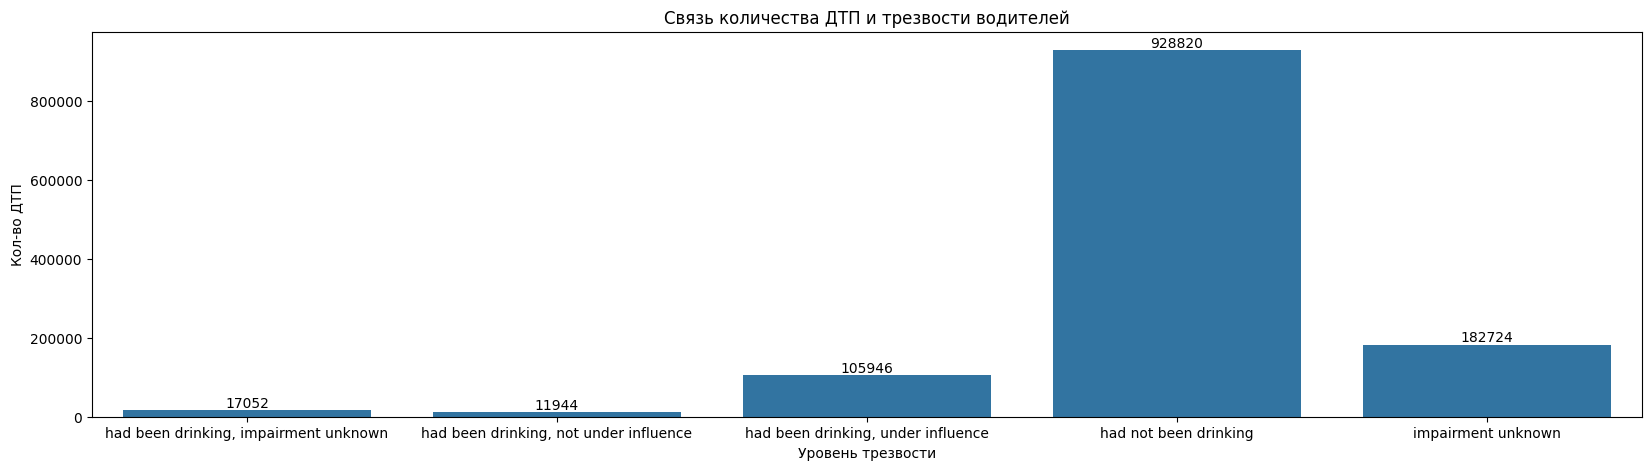

In [128]:
plt.figure(figsize=(20, 5))
barplot = sns.barplot(res, x='party_sobriety', y='collisions_count')
plt.title('Связь количества ДТП и трезвости водителей')
plt.xlabel('Уровень трезвости')
plt.ylabel('Кол-во ДТП')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom')

plt.show()

Огромная часть ДТП была по вине трезвых водителей. Посмотрим, зависит ли количество виновных в ДТП в зависимости от уровня опьянения.

In [129]:
query = '''
SELECT party_sobriety,
       AVG(at_fault) AS fault_part
FROM parties
WHERE party_sobriety NOT IN ('None', 'not applicable')
GROUP BY party_sobriety
ORDER BY fault_part
'''

In [130]:
res = pd.read_sql(query, engine)
res

,party_sobriety,fault_part
0,had not been drinking,0.4371
1,"had been drinking, not under influence",0.6767
2,impairment unknown,0.7846
3,"had been drinking, impairment unknown",0.7961
4,"had been drinking, under influence",0.9425


Результаты подтверждают догадки. Если в ДТП участвует пьяный водитель, то с очень большим шансом виноват именно он. В случае если алкоголь оказал влияние, этот показатель достигается практически `95%`. Если же водитель не пил, то он является виновником ДТП лишь в `44%`. Поэтому данный признак является неким "маркером" и имеет смысл установить в автомобиль анализатор алкогольного опьянения.

## 8. <a id='toc8_'></a>Общий вывод     [&#8593;](#toc0_)

В рамках данного проекта мы работали с базой данных о различных ДТП. Основная информация представлена в 3 таблицах:
- `collisions` - информация о происшествиях
- `parties` - описание участников происшествия
- `vehicles` - описание автомобиля

Задача проекта - создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. По пожеланиям заказчика учитываются случаи только за 2012, когда ДТП привело к любым повреждениям автомобиля, кроме царапин.

В начале была проведена аналитическая работа и были исследованы различные гипотезы. Например, март оказался месяцем с наибольшим количеством ДТП в среднем. Несколько задач было делегировано коллегам.

Далее данные из таблиц с помощью SQL были объединены, отфильтрованы и выгружены в датафрейм. Большу́ю часть признаков нельзя использовать при моделировании, так как эти признаки будут известны лишь после ДТП. Поэтому были взяты лишь признаки, известные на момент начала поездки.

Было обнаружены чуть меньше `40%` полных дубликатов (скорее всего из-за удаления большого числа признаков). Часть признаков имела большу́ю часть пропусков (`location_type - 51%`, `control_device - 72%`, `party_drug_physical - 89%`).

Далее были протестированы 3 различные модели с подбором гиперпараметров через `hyperopt`. Результаты представлены в таблице ниже:

| Model                  | ROC_AUC |
|------------------------|---------|
| CatBoostClassifier     | 0.6873  |
| LGBMClassifier         | 0.6856  |
| RandomForestClassifier | 0.6829  |

Как видно, все модели показали крайне похожие результаты. Однако с небольшим отрывом все же побеждает `CatBoostClassifier`.

Самым важным признаком является `party_sobriety`, то есть трезвость водителя. В целом, этот признак невозможно оценить в момент начала поездки, однако можно установить анализатор алкогольного опьянения, так как пьяные водители куда чаще является виновниками ДТП.

В результате проекта я считаю, что создать адекватную систему просчета риска ДТП в момент начала поездки **НЕвозможно**.

